## Practical Applications with Neural Network Surrogates

General idea of most applications: replace high fidelity model, usually correspoding to the solution of a PDE, with the network model trained with a set generate by solving the PDE $N$ times.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
import seaborn as sb

# Adapt this import to your specific directory tree.
from Common import NeuralNet, fit
torch.manual_seed(42)

## Motivation and classical methods

Consider the parametric one-dimensional heat equation:

$$
u_t(t, x, y) = ku_{xx}(t, x, y), \quad x\in [0,1], t\in[0,T], y\in[0,1]^d
$$

with zero Dirichlet boundary conditions and parametrized initial condition
$$
u_0(x,y) = \sum_{j=1}^d (2y_j -1 ) \sin(2\pi j x)
$$
The observable is the heat flux at $(T,0)$:
$$
L(y) = -k\frac{\partial T}{\partial x}|_{t=T,x=0}
$$

The heat equation can be solved with a simple finite difference scheme given a mesh with grid sizes $\Delta x$ and $\Delta t$, and the heat flux computed from the resulting numerical approximation. 
Let us define the approximate flux as $L^\Delta$.

We are interested in the input to the observable map:
$$
L: y \mapsto L^\Delta(y), \quad y\in[0,1]^d
$$

In [3]:
def initial_condition(x, y):
  # Generate perturbed initial condition.
  ic = torch.zeros_like(x)
  for i in range(y.shape[0]):
      ic = ic + y[i] * torch.sin((2 + i) * np.pi * x) 
  ic = ic / torch.mean(ic ** 2)**0.5
  return ic


def solve_heat_eq(y):
  # http://hplgit.github.io/num-methods-for-PDEs/doc/pub/diffu/html/._diffu-solarized001.html
  # Typical heat equation solver.
  nx = 51
  x = torch.linspace(0,1, nx)
  T = 0.01
  ic = initial_condition(x,y)

  diff = 1
  dx = x[1] - x[0]
  dt = 0.5 * dx ** 2 / diff

  F = diff * dt / dx ** 2
  nt = int((T / dt))
  nx = x.shape[0]

  u_old = torch.clone(ic)
  u_new = torch.zeros_like(ic)

  for k in range(1, nt):
      for i in range(1, nx - 1):
          u_new[i] = (
              u_old[i] + F * (u_old[i + 1] - 2 * u_old[i] + u_old[i - 1]))
      u_new[0] = 0
      u_new[-1] = 0

      u_old[:] = u_new

  flux = -diff * (u_new[0] - u_new[1]) / dx
  return flux, (x, ic, u_new)


###############################
Generating Training Set
###############################


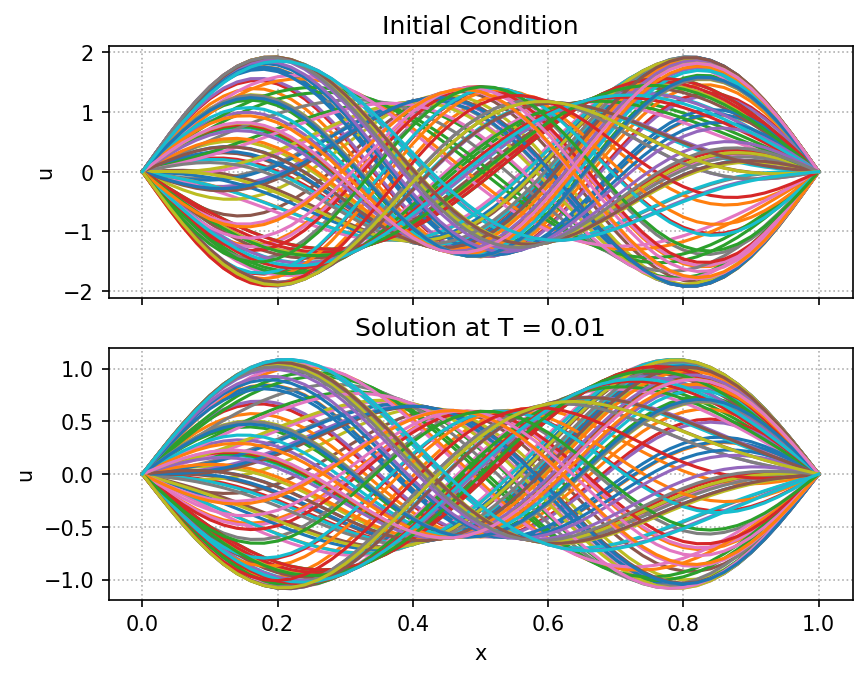

In [4]:
print("###############################")
print("Generating Training Set")
torch.manual_seed(12446)
n_samples = 100
sobol = False
min_inputs = -5
max_inputs = 5
d = 2
# Inputs for generating the training set are in [-5,5]
if not sobol:
    y_rand = torch.rand((n_samples, d))
    y = (max_inputs - min_inputs) * y_rand + min_inputs
else:
    sob_eng = torch.quasirandom.SobolEngine(d)
    sob_eng.fast_forward(1)
    y_sob = sob_eng.draw(n_samples)
    y = (max_inputs - min_inputs)*y_sob + min_inputs
training_set = torch.zeros((n_samples, y.shape[1] + 1))


print("###############################")
fig, axs = plt.subplots(2, dpi=150)
axs[0].grid(True, which="both", ls=":")
axs[1].grid(True, which="both", ls=":")
for j in range(n_samples):
    f, (x, ic, u_end) = solve_heat_eq(y[j])
    training_set[j, :d] = y[j]
    training_set[j, -1] = f
    axs[0].plot(x, ic)
    axs[1].plot(x, u_end)
    
axs[0].set(ylabel='u')
axs[1].set(xlabel='x', ylabel='u')
axs[0].set_title("Initial Condition")
axs[1].set_title("Solution at T = 0.01")
for ax in fig.get_axes():
    ax.label_outer()

In [5]:
# Setup dataset for training.
if not sobol:
    inputs = y_rand
else:
    inputs = y_sob
output = training_set[:, -1].reshape(-1, 1)

batch_size = inputs.shape[0]
training_set_loader = DataLoader(
    torch.utils.data.TensorDataset(inputs, output), 
    batch_size=batch_size,
    shuffle=True)

## Neural Surrogates

Since actually solving PDEs from scratch for every perturbation of the initial condition is quite an expensive process, we shall instead opt for a neural approximation. 


This amounts to learning a neural approximant (parameterized by $\theta$)

$$
\hat{L}_\theta: y \mapsto \hat{L}_\theta^\Delta(y), \quad y\in[0,1]^d
$$

which is trained to map $y$'s to pre-computed observables at a pre-determined number of query points (i.e. your dataset).


In [6]:
# Setup model and optimizer.
model = NeuralNet(input_dimension=inputs.shape[1], 
                  output_dimension=output.shape[1], 
                  n_hidden_layers=4, 
                  neurons=20, 
                  regularization_param=0.0, 
                  regularization_exp=2,
                  retrain_seed=128)

optimizer_ = optim.LBFGS(
    model.parameters(),
    lr=0.1, max_iter=1,
    max_eval=50000,
    tolerance_change=1.0 * np.finfo(float).eps
)

n_epochs = 2500
history = fit(
    model, training_set_loader, n_epochs, optimizer_, p=2, verbose=False)
print("Final Training loss: ", history[-1])

Final Training loss:  9.814268651098246e-07


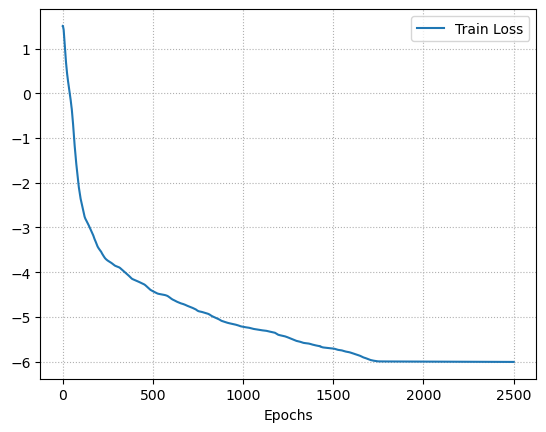

In [7]:
plt.figure()
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, n_epochs + 1), np.log10(history), label="Train Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [11]:
from tqdm import tqdm
def generate_test_set(n_samples):
    torch.manual_seed(34)
    inputs_ = (
        (max_inputs - min_inputs) * torch.rand((n_samples, d)) + min_inputs)
    s_ = torch.zeros((n_samples, d + 1))

    print("###############################")
    print("Generating Test Set")
    for j in tqdm(range(n_samples)):
        s_[j, :d] = inputs_[j]
        s_[j, -1], _ = solve_heat_eq(inputs_[j])

    return s_

test_set = generate_test_set(1000)

###############################
Generating Test Set


100%|████████████████████████████████████████████████████████████| 1000/1000 [00:37<00:00, 26.51it/s]


In [12]:
test_inputs = test_set[:, :d]
test_output = test_set[:, -1]

test_inputs_scaled = (test_inputs - min_inputs)/(max_inputs - min_inputs)

test_pred = model(test_inputs_scaled).reshape(-1, ) 
err = (
    torch.mean(
        (test_output - test_pred) ** 2) / torch.mean(test_output ** 2)) ** 0.5

print("Error Model : ", err.item())

Error Model :  0.030263418331742287


Text(0.5, 1.0, 'Approximate Solution')

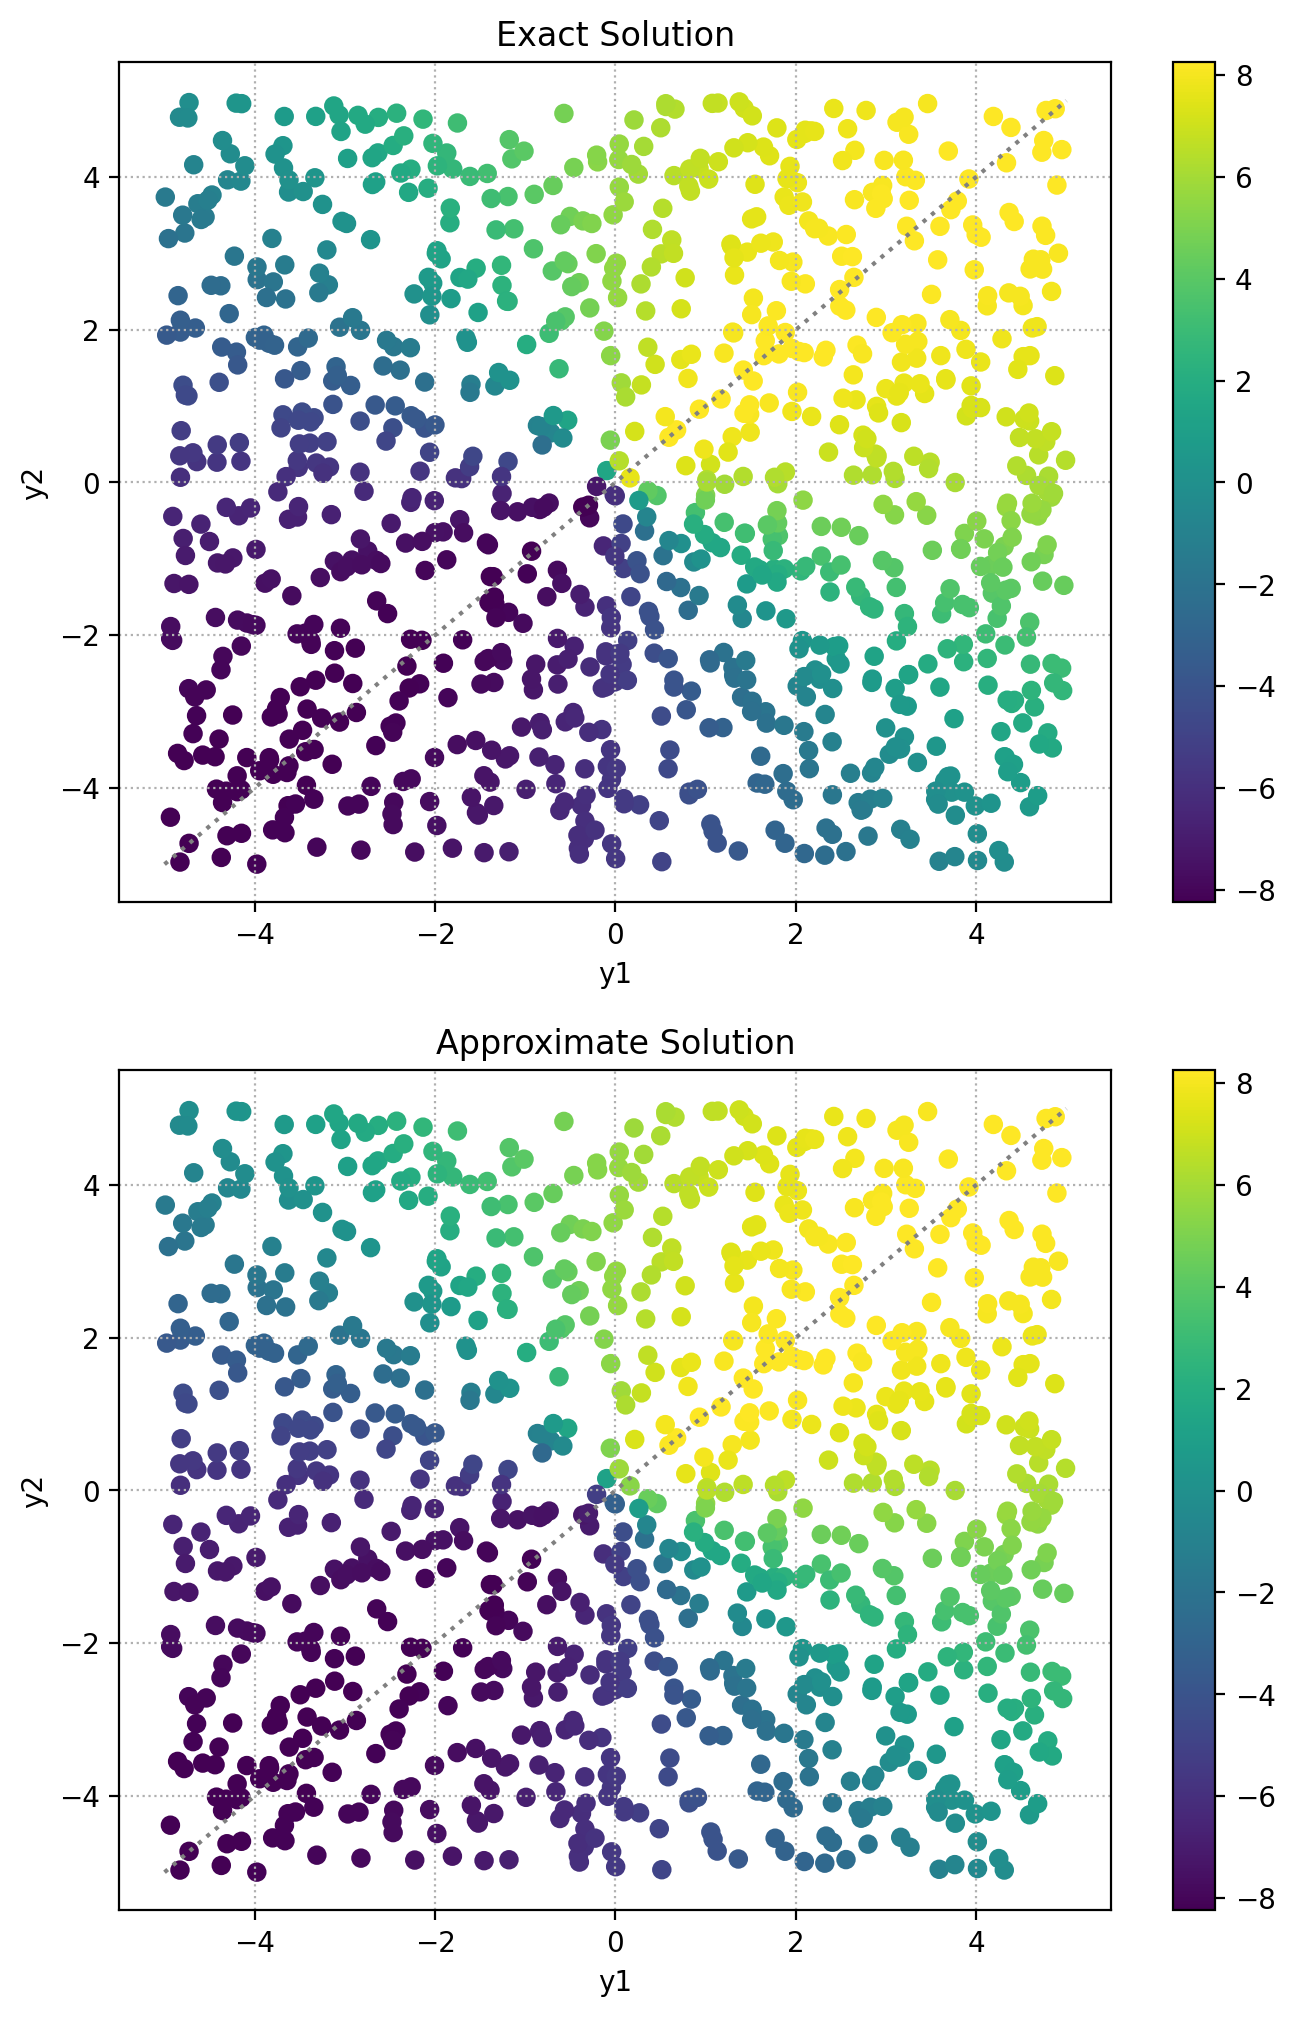

In [13]:
y1=torch.linspace(-5,5, 10000)
fig, axs = plt.subplots(2, figsize=(8,12), dpi=200)
im1 = axs[0].scatter(test_inputs[:,0], test_inputs[:,1], c=test_output)
axs[0].set_xlabel("y1")
axs[0].set_ylabel("y2")
plt.colorbar(im1,ax=axs[0])
axs[0].plot(y1,y1, color="grey", ls=":")
axs[0].grid(True, which="both", ls=":")
im2 = axs[1].scatter(test_inputs[:,0], test_inputs[:,1], c=test_pred.detach())
axs[1].set_xlabel("y1")
axs[1].set_ylabel("y2")
plt.colorbar(im2,ax=axs[1])
axs[1].plot(y1,y1, color="grey", ls=":")
axs[1].grid(True, which="both", ls=":")
axs[0].set_title("Exact Solution")
axs[1].set_title("Approximate Solution")

## Uncertainty Quantification

In this subsection we look at the distribution of the flux values, and qualitatively compare the results we get from the surrogate approach of getting the flux vs. the finite difference method.

Since different discretizations of $y$ lead to variation in the approximate distribution of $f = L(y)$, we showcase these effects via plotting the distribution corresponding to the $y$'s in the trraining set, versus randomply sampled $y$ values.

/tmp/ipykernel_308200/1436308028.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(outputs_for_UQ, label="P(f) [f := NN(y), 10k random y samples]")
/tmp/ipykernel_308200/1436308028.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(output, label="P(f) [f := finite_diff(y), 100 Sobol points]")
/

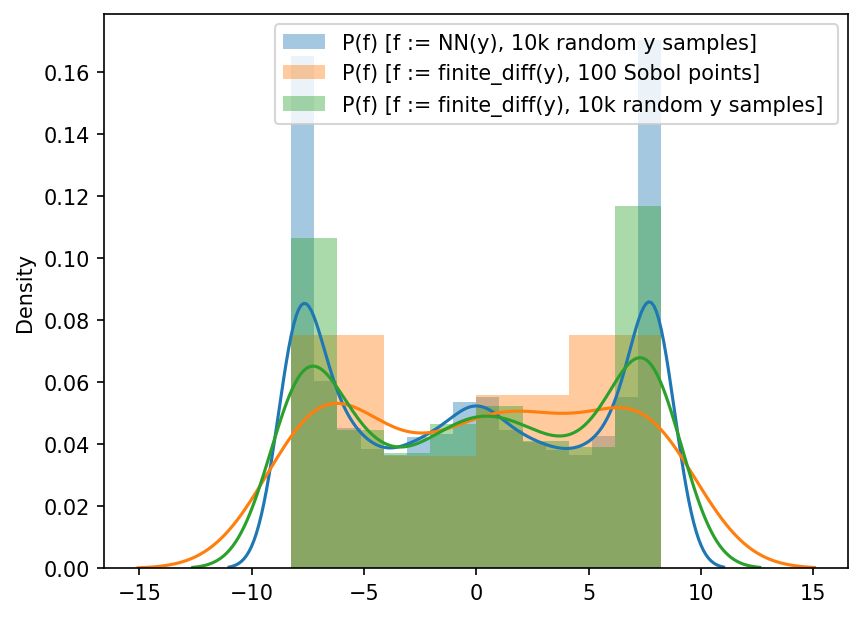

In [14]:
inputs_for_UQ = torch.rand((10000, 2))
outputs_for_UQ = model(inputs_for_UQ).reshape(-1,).detach()

plt.figure(dpi=150)
sb.distplot(outputs_for_UQ, label="P(f) [f := NN(y), 10k random y samples]")
sb.distplot(output, label="P(f) [f := finite_diff(y), 100 Sobol points]")
sb.distplot(test_output,
            label="P(f) [f := finite_diff(y), 10k random y samples] ")
plt.legend()
plt.show()

## Optimal Design

We want to find a value of the input variables $y$ that maximizes the flux $q$:
$$
y_{opt, exact} = \arg\max_{y\in[0,1]^d} q(y)
$$

In order to solve the problem we employ the DNNOPT algorithm, that boils down to replacing the model $q(y)$ with the neural network previously trained $q^*(y)$ and solving the maximization problem:
$$
y_{opt} = \arg\max_{y\in[0,1]^d} q^*(y) 
$$

In [15]:
y_opt = torch.tensor(torch.tensor([0.5, 1.24]), requires_grad=True)
y_init = torch.clone(y_opt)

optimizer = optim.LBFGS(
      [y_opt],
      lr=float(0.00001),
      max_iter=50000,
      max_eval=50000,
      history_size=100,
      line_search_fn="strong_wolfe",
      tolerance_change=1.0 * np.finfo(float).eps
)

optimizer.zero_grad()
cost = list([0])

def closure():
    y_tilde = ((
        torch.clamp(y_opt, min=min_inputs, max=max_inputs) - min_inputs) /
        (max_inputs - min_inputs))
    G = -model(y_tilde)
    cost[0] = G
    G.backward()
    return G


optimizer.step(closure=closure)
print("Minimizer: ", torch.clamp(y_opt, min=min_inputs, max=max_inputs))
print("Corresponding flux values: ", 
      model(
          (torch.clamp(y_opt, min=min_inputs, max=max_inputs) - min_inputs) / 
          (max_inputs - min_inputs)
          )
      )

f_opt, (x,ic,u) = solve_heat_eq(
    torch.clamp(y_opt, min=min_inputs, max=max_inputs))

/tmp/ipykernel_308200/739687020.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_opt = torch.tensor(torch.tensor([0.5, 1.24]), requires_grad=True)


Minimizer:  tensor([1.0767, 0.9398], grad_fn=<ClampBackward1>)
Corresponding flux values:  tensor([8.2426], grad_fn=<AddBackward0>)


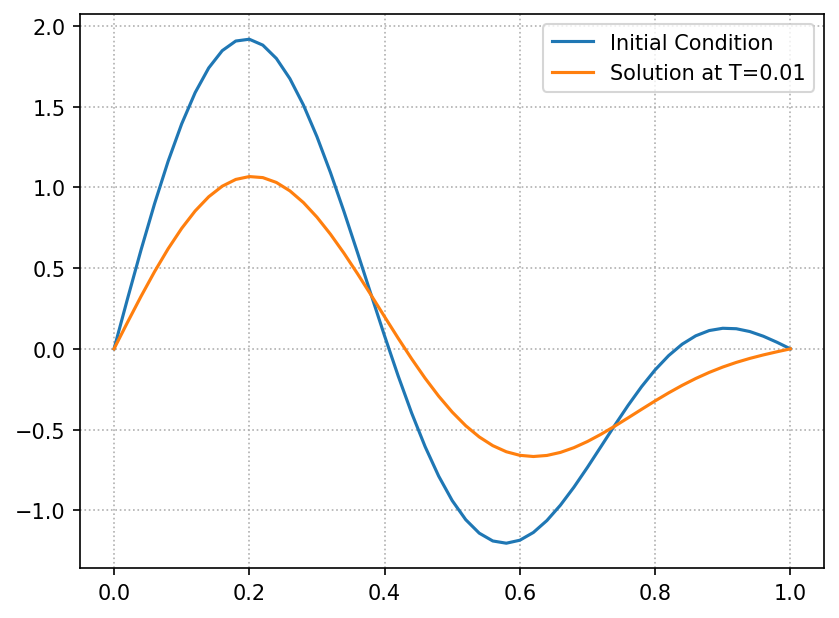

In [16]:
plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(x, ic.detach(),label="Initial Condition")
plt.plot(x, u.detach(), label="Solution at T=0.01")
plt.legend()

/tmp/ipykernel_308200/491155281.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_opt_ex = torch.tensor(torch.tensor([0.5, 1.24]), requires_grad=True)


Exact Minimizer:  tensor([1.0589, 0.9732], grad_fn=<ClampBackward1>)


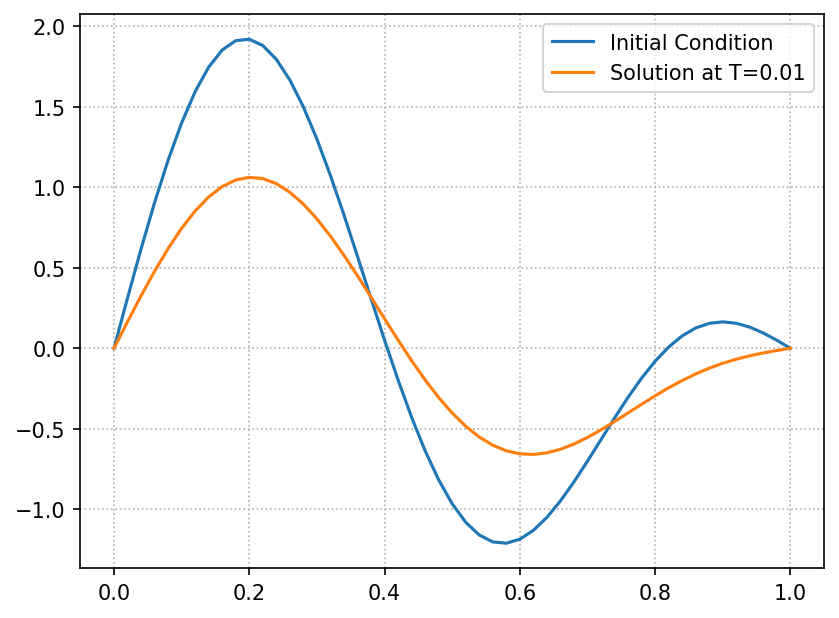

In [18]:
y_opt_ex = torch.tensor(torch.tensor([0.5, 1.24]), requires_grad=True)
y_init = torch.clone(y_opt_ex)

optimizer = optim.LBFGS(
    [y_opt_ex],
    lr=float(0.00001),
    max_iter=5000,
    max_eval=5000,
    history_size=100,
    line_search_fn="strong_wolfe",
    tolerance_change=1.0 * np.finfo(float).eps
)

optimizer.zero_grad()
cost = list([0])

def closure():
    G, _ = solve_heat_eq(
        torch.clamp(y_opt_ex, min=min_inputs, max=max_inputs))
    G = -G
    cost[0] = G
    G.backward()
    return G


optimizer.step(closure=closure)
print("Exact Minimizer: ", torch.clamp(y_opt_ex, min=min_inputs, max=max_inputs))

f_opt_ex, (x,ic,u) = solve_heat_eq(
    torch.clamp(y_opt_ex, min=min_inputs, max=max_inputs))

plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(x, ic.detach(),label="Initial Condition")
plt.plot(x, u.detach(), label="Solution at T=0.01")
plt.legend()

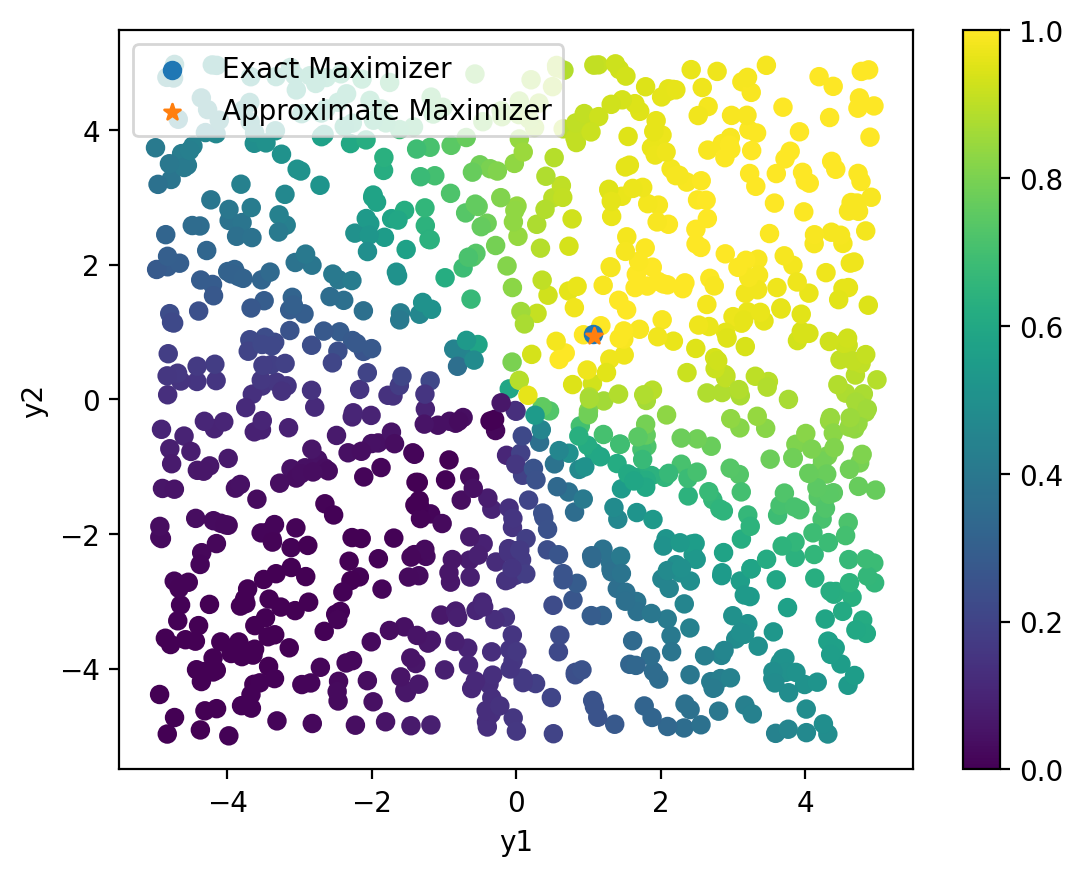

In [19]:
plt.figure(dpi=200)
plt.scatter(test_inputs[:,0], test_inputs[:,1], c=test_output)
plt.scatter(y_opt_ex[0].detach(), y_opt_ex[1].detach(), marker = "o", label = "Exact Maximizer")
plt.scatter(y_opt[0].detach(), y_opt[1].detach(), marker = "*", label = "Approximate Maximizer")
plt.colorbar()
plt.xlabel("y1")
plt.ylabel("y2")
plt.legend()
plt.show()